We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [33]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(32*32*3,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(32*32*3, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:

In [34]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [35]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [36]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [37]:
from keras.datasets import cifar10
import numpy as np
(x_train, _), (x_test, _) = cifar10.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [38]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


Now let's train our autoencoder for 50 epochs:

In [39]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s - loss: 0.6846 - val_loss: 0.6700
Epoch 2/20
50000/50000 [==============================] - 4s - loss: 0.6583 - val_loss: 0.6508
Epoch 3/20
50000/50000 [==============================] - 4s - loss: 0.6458 - val_loss: 0.6403
Epoch 4/20
50000/50000 [==============================] - 4s - loss: 0.6355 - val_loss: 0.6327
Epoch 5/20
50000/50000 [==============================] - 4s - loss: 0.6283 - val_loss: 0.6261
Epoch 6/20
50000/50000 [==============================] - 4s - loss: 0.6235 - val_loss: 0.6223
Epoch 7/20
50000/50000 [==============================] - 4s - loss: 0.6199 - val_loss: 0.6211
Epoch 8/20
50000/50000 [==============================] - 4s - loss: 0.6163 - val_loss: 0.6157
Epoch 9/20
50000/50000 [==============================] - 4s - loss: 0.6127 - val_loss: 0.6121
Epoch 10/20
50000/50000 [==============================] - 4s - loss: 0.6093 - val_loss: 0.6113

After 20 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.096. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [46]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

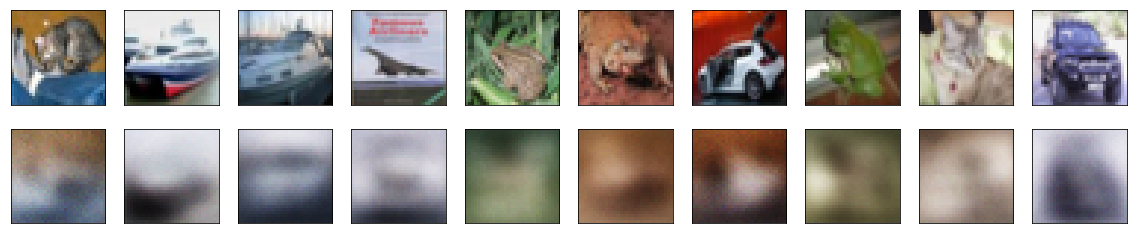

In [47]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

### Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [44]:
input_img = Input(shape=(32*32*3,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(32*32*3, activation='sigmoid')(decoded)

Let's try this:

In [45]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s - loss: 0.6844 - val_loss: 0.6709
Epoch 2/50
50000/50000 [==============================] - 8s - loss: 0.6539 - val_loss: 0.6482
Epoch 3/50
50000/50000 [==============================] - 8s - loss: 0.6387 - val_loss: 0.6430
Epoch 4/50
50000/50000 [==============================] - 8s - loss: 0.6289 - val_loss: 0.6216
Epoch 5/50
50000/50000 [==============================] - 8s - loss: 0.6211 - val_loss: 0.6177
Epoch 6/50
50000/50000 [==============================] - 8s - loss: 0.6145 - val_loss: 0.6117
Epoch 7/50
50000/50000 [==============================] - 8s - loss: 0.6103 - val_loss: 0.6079
Epoch 8/50
50000/50000 [==============================] - 8s - loss: 0.6075 - val_loss: 0.6090
Epoch 9/50
50000/50000 [==============================] - 8s - loss: 0.6058 - val_loss: 0.6047
Epoch 10/50
50000/50000 [==============================] - 9s - loss: 0.6047 - val_loss: 0.6063

After 100 epochs, it reaches a train and test loss of ~0.0915, a bit better than our previous models. Our reconstructed digits look a bit better too:

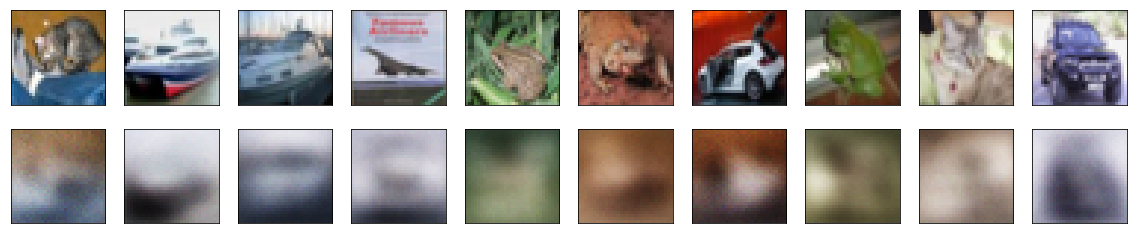

In [48]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [64]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(32, 32, 3))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train it, we will use the original CIFAR10 digits with shape (samples, 3, 32, 32), and we will just normalize pixel values between 0 and 1.

In [65]:
from keras.datasets import cifar10
import numpy as np

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))
print(x_train.shape)

(50000, 32, 32, 3)


In [66]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s - loss: 0.6208 - val_loss: 0.5974
Epoch 2/20
50000/50000 [==============================] - 11s - loss: 0.5936 - val_loss: 0.5884
Epoch 3/20
50000/50000 [==============================] - 11s - loss: 0.5869 - val_loss: 0.5859
Epoch 4/20
50000/50000 [==============================] - 12s - loss: 0.5836 - val_loss: 0.5826
Epoch 5/20
50000/50000 [==============================] - 11s - loss: 0.5814 - val_loss: 0.5821
Epoch 6/20
50000/50000 [==============================] - 12s - loss: 0.5802 - val_loss: 0.5799
Epoch 7/20
50000/50000 [==============================] - 11s - loss: 0.5791 - val_loss: 0.5804
Epoch 8/20
50000/50000 [==============================] - 12s - loss: 0.5784 - val_loss: 0.5786
Epoch 9/20
50000/50000 [==============================] - 11s - loss: 0.5776 - val_loss: 0.5795
Epoch 10/20
50000/50000 [==============================] - 12s - loss: 0.5770 - val_lo

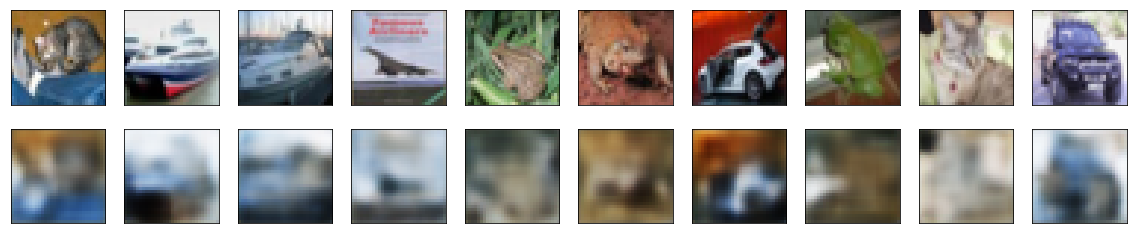

In [67]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()